# Regression problem

In this problem, set by my tutor, I tried to predict the "feels like" temperature from some other variables, using some guidance and suggested links, but otherwise the (clumsy) code below is my own. 

I was provided with train and test set, and I trained a random forest regressor from sklearn. By comparing it with a [similar piece of work](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile) done in Kaggle, I identified the collinear data and removed them, which I interestingly didn't actually reduce the MSE. 

## Initialising data

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# from sklearn.ensemble import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel

In [37]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Taking out the datetime columns
dt_train = train['datetime']
dt_test = test['datetime']

# Initialising a blank list, so I can append the unpacked values to it 
dts_train = []
dts_test = []
for i in range(0,len(dt_train)):
    dts_train.append(datetime.strptime(dt_train[i], "%m/%d/%y %H:%M")) 
for i in range(0,len(dt_test)):
    dts_test.append(datetime.strptime(dt_test[i], "%m/%d/%y %H:%M")) 

# Also pulling out the perceived temp so this can be excluded from the regression later 
test_atemp = test['atemp']
train_atemp = train['atemp']

# Now putting the reformatted datetimes back in and 
train['datetime'] = dts_train
train = train.drop(['atemp'],axis=1)
train = train.set_index('datetime')
test['datetime'] = dts_test
test = test.drop(['atemp'],axis=1)
test = test.set_index('datetime')

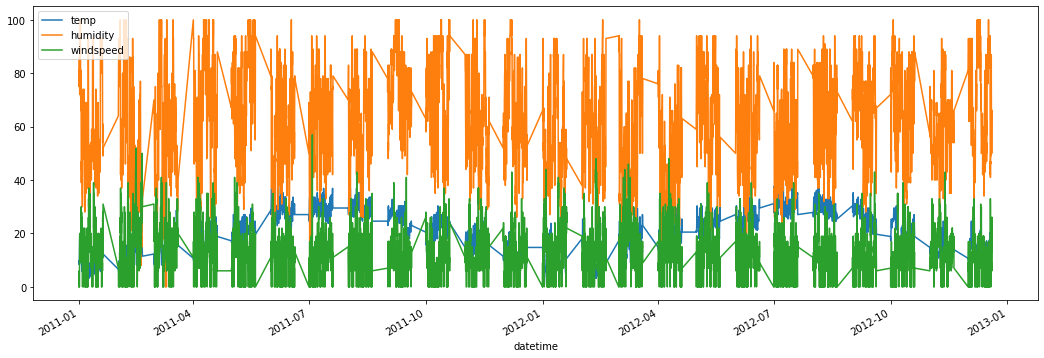

In [38]:
train.plot(figsize=(18,6))

## Random forest regression

In [39]:
# Code from Kaggle https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
from sklearn.ensemble import RandomForestRegressor
# This creates the random forest regression
rfModel = RandomForestRegressor(n_estimators=1000) 
rfModel.fit(train,train_atemp)
# predictions, one on the training data, one on the test data
train_preds = rfModel.predict(train) 
test_preds = rfModel.predict(test)

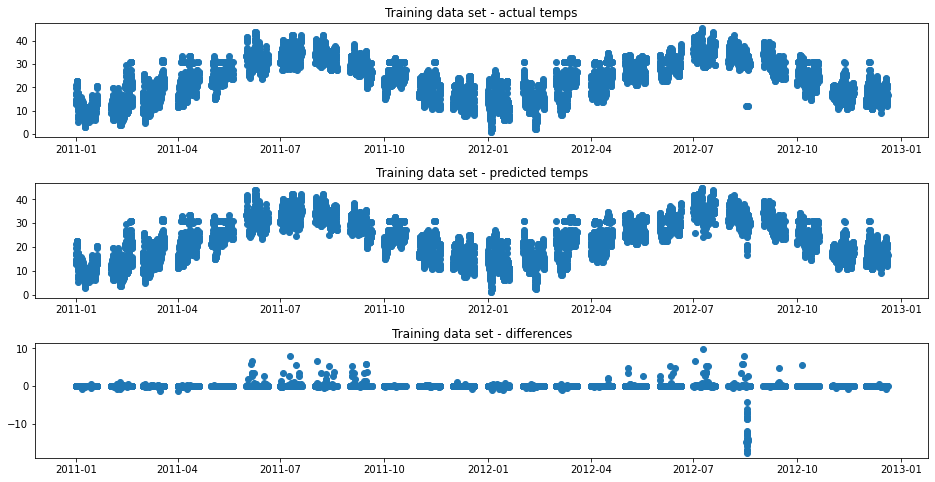

In [40]:
# Making a figure to compare them
fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(3,1,1)
ax1.title.set_text('Training data set - actual temps')
ax1.scatter(dts_train,train_atemp)
# 
ax2 = fig.add_subplot(3,1,2)
ax2.title.set_text('Training data set - predicted temps')
ax2.scatter(dts_train,train_preds)
# 
diffs = train_atemp - train_preds
ax3 = fig.add_subplot(3,1,3)
ax3.title.set_text('Training data set - differences')
ax3.scatter(dts_train,diffs)

# It looks like the variances are in August - Sep 2012, was there any extreme weather then?
# There's a bunch of cold values in the period, see the outlier spots (could do graph to zoom in)
# Also these chunks of timestamps are because the data are 20-31 of each month (splitting the data)

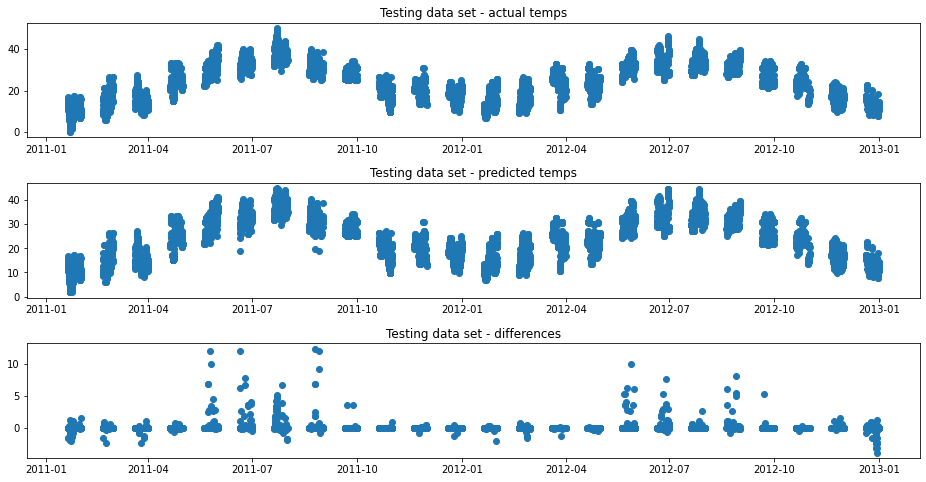

In [27]:
# Making a figure to compare them
fig2 = plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)
ax4 = fig2.add_subplot(3,1,1)
ax4.title.set_text('Testing data set - actual temps')
ax4.scatter(dts_test,test_atemp)
# 
ax5 = fig2.add_subplot(3,1,2)
ax5.title.set_text('Testing data set - predicted temps')
ax5.scatter(dts_test,test_preds)
# 
diffs_test = test_atemp - test_preds
ax6 = fig2.add_subplot(3,1,3)
ax6.title.set_text('Testing data set - differences')
ax6.scatter(dts_test,diffs_test)

# It looks like the variances are in August - Sep 2012, was there any extreme weather then?
# Also these chunks of timestamps are because the data are 20-31 of each month (splitting the data)


### MSE

In [8]:
test_errors = (test_preds - test_atemp)**2
train_errors = (train_preds - train_atemp)**2
print('Training MSE:', round(np.mean(train_errors), 3), 'degrees celsius.')
print('Test MSE:', round(np.mean(test_errors), 3), 'degrees celsius.')

Training MSE: 0.451 degrees celsius.
Test MSE: 0.378 degrees celsius.


In [142]:
print('Train standard deviation :', round(train_atemp.std(),3)) # Since the standard deviation is 8.47 having MSE of 0.36 seems ok
print('Test standard deviation :', round(test_atemp.std(),3)) # Since the standard deviation is 8.47 having MSE of 0.36 seems ok

Train standard deviation : 8.475
Test standard deviation : 8.783


**Removing features**

We should remove features that are correlated, due to problems of multicollinearity

https://en.wikipedia.org/wiki/Multicollinearity#Consequences

Plot uses https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

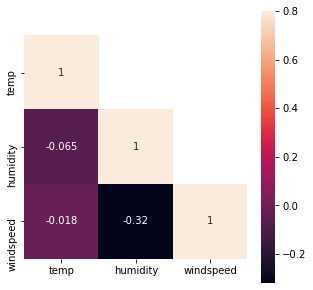

In [14]:
import seaborn as sn
corrMatt = train[["temp","humidity","windspeed"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(5,5)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

### Removing humidity

In [41]:
train2 = train.drop(['humidity'],axis=1)
test2 = test.drop(['humidity'],axis=1)

In [44]:
rfModel2 = RandomForestRegressor(n_estimators=1000) 
rfModel2.fit(train2,train_atemp)
# predictions, one on the training data, one on the test data
train2_preds = rfModel2.predict(train2) # don't need this 
test2_preds = rfModel2.predict(test2)

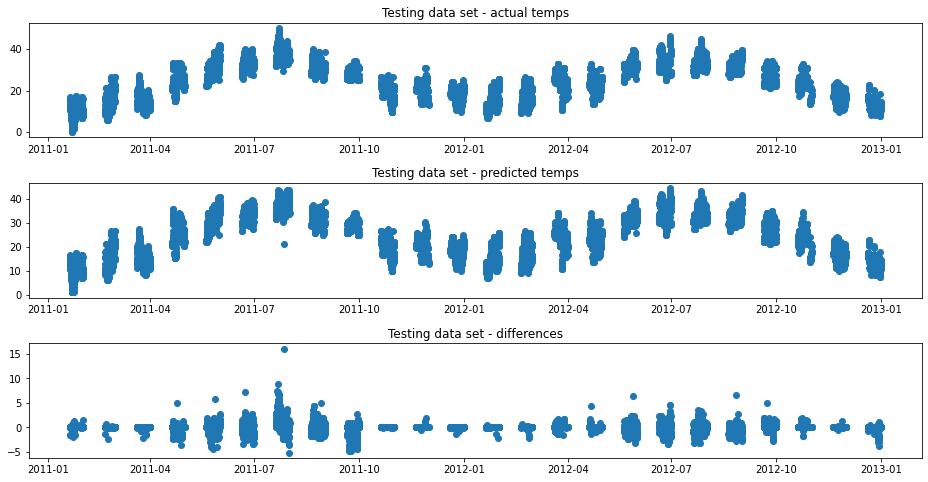

In [45]:
# Making a figure to compare them
fig3 = plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)
ax7 = fig3.add_subplot(3,1,1)
ax7.title.set_text('Testing data set - actual temps')
ax7.scatter(dts_test,test_atemp)
# 
ax8 = fig3.add_subplot(3,1,2)
ax8.title.set_text('Testing data set - predicted temps')
ax8.scatter(dts_test,test2_preds) # this has the new preds
# 
diffs_test = test_atemp - test2_preds # incorporates new preds here
ax9 = fig3.add_subplot(3,1,3)
ax9.title.set_text('Testing data set - differences')
ax9.scatter(dts_test,diffs_test) 

In [46]:
test_errors = (test2_preds - test_atemp)**2
train_errors = (train2_preds - train_atemp)**2
print('Training MSE:', round(np.mean(train_errors), 3), 'degrees celsius.')
print('Test MSE:', round(np.mean(test_errors), 3), 'degrees celsius.')

Training MSE: 1.17 degrees celsius.
Test MSE: 0.895 degrees celsius.


In [47]:
print('Train standard deviation :', round(train_atemp.std(),3)) 
print('Test standard deviation :', round(test_atemp.std(),3)) 

Train standard deviation : 8.475
Test standard deviation : 8.783


#### With windspeed

* Training MSE: 0.451 degrees celsius.
* Test MSE: 0.378 degrees celsius.

#### Without windspeed

* Training MSE: 1.17 degrees celsius.
* Test MSE: 0.895 degrees celsius.

## Conclusion
* Humidity and windspeed are negatively correlated
* The best fit appears to be when all the features are maintained
* There are some anomalies in August - Sep 2012, but it looks like these go away when windspeed is dropped
* Potentially August - Sep 2012 was abnormally windy - could explore this by doing monthly or rolling averages

**Notes**
* Ensemble learning - takes multiple predictions from different algorithms or runs
* Model made of several is an 'ensemble learning model'
* Two flavours: boosting is about increasing accuracy?, bagging is about splitting apart training data
* Random forest is bagging, and makes multiple decision trees (thus forest...)
* You do random forest by picking out subset of training data and making individual decision trees
* Decision trees asks a question and then chooses different answers depending on inputs 
* Decision tree output can be categorical or numerical
* Top of tree is called root/root node, ends are leaf nodes or just 'leaves'
* Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. 
* An ensemble of randomized decision trees is known as a random forest.


*Python for Data Science textbook - chapter on decision trees and random forests*

https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html